# Homework 2
---
TED Talks classification

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import random as rnd
import os
import nltk
import pickle
import string
import itertools
import pymorphy2
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from collections import Counter, deque

sns.set_style('whitegrid')
sns.despine

% pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

In [2]:
train_data = pd.read_json('./data/ted_ru-20160408.json.train')
train_data['class'] = train_data['class'] - 1
test_data = pd.read_json('./data/ted_ru-20160408.json.test')

train_data.head()

,@id,class,content,head
0,1848,1,"Я был неописуемо удивлён, узнав о существовани...","{u'charnum': 18349, u'videourl': u'http://down..."
1,881,1,Я работаю с бактериями. Сейчас я покажу вам сд...,"{u'charnum': 2214, u'videourl': u'http://downl..."
2,1757,0,"Привет, я здесь чтобы поговорить с вами о важн...","{u'charnum': 3713, u'videourl': u'http://downl..."
3,1199,0,Я глава отдела развития общественной организац...,"{u'charnum': 2932, u'videourl': u'http://downl..."
4,1855,5,"Я думаю, мой взгляд на простоту можно отлично ...","{u'charnum': 15976, u'videourl': u'http://down..."


In [3]:
train_data.describe()

,@id,class
count,1640.000000,1640.000000
mean,1029.590854,1.164634
std,593.742888,1.721548
min,1.000000,0.000000
25%,511.750000,0.000000
50%,1024.500000,0.000000
75%,1545.250000,2.000000
max,2050.000000,7.000000


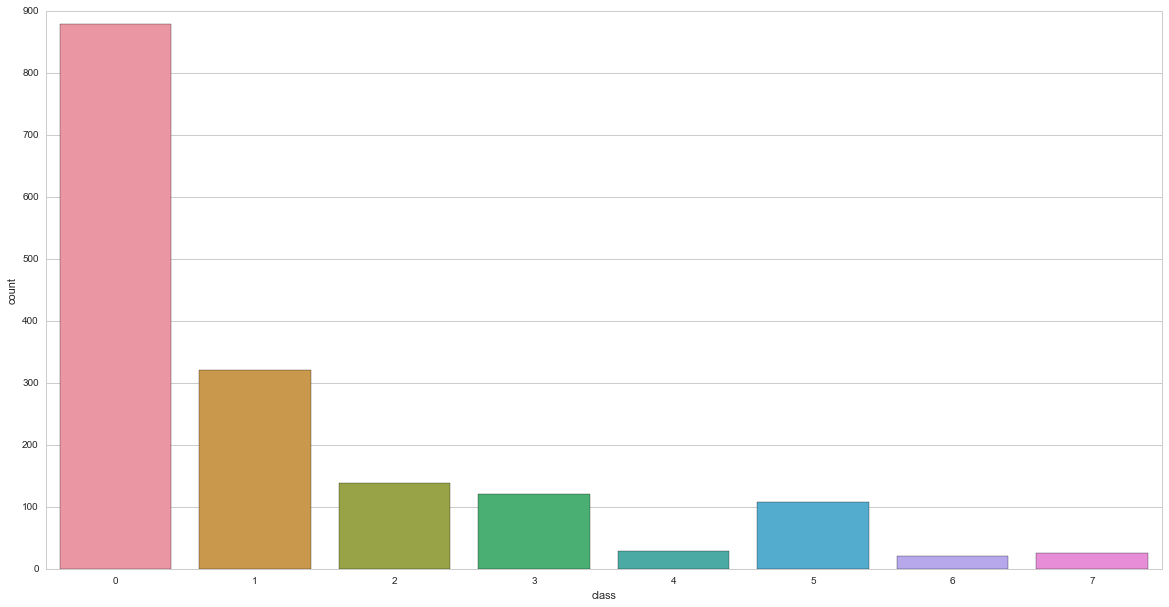

In [4]:
plt.figure(figsize=(20,10))
sns.countplot(train_data['class'])

In [5]:
def make_submission(answers):
    res = pd.DataFrame(columns=['id', 'class'])
    
    for i, iden in enumerate(test_data['@id']):
        res = res.append(pd.DataFrame(np.array([[str(iden), answers[i]]]), columns=['id', 'class']),
                         ignore_index=True)
    
    with open('./results/submission.csv', 'w') as fout:
        res.to_csv(fout, index=False, sep=',')

In [6]:
def tokenize(data, source='train', filename=None):
    if filename is None:
        morph = pymorphy2.MorphAnalyzer()

        tokenized = []
        words = []

        for item in data:
            item = nltk.word_tokenize(item.lower())
            item = [w for w in item if w not in string.punctuation]
            item = [w for w in item if w[0] in u'абвгдеёжзиклмнопрстуфхцчшщъыьэюя']
            item = [morph.parse(w)[0].normal_form for w in item]
            tokenized.append(item)
            words.extend(item)

        with open('./dump/words-%s.dump' % source, 'w') as fout:
            pickle.dump(words, fout)

        with open('./dump/tokenized-%s.dump' % source, 'w') as fout:
            pickle.dump(tokenized, fout)
    else:
        with open('./dump/tokenized-%s.dump' % source, 'r') as fin:
            tokenized = pickle.load(fin)
        with open('./dump/words-%s.dump' % source, 'r') as fin:
            words = pickle.load(fin)
    return tokenized, words

def build_corpus(train_tokenized, test_tokenized, train_words, test_words):
    word_to_index = {}
    index_to_word = {}
    word_count = []
    train_dataset = []
    test_dataset = []
    
    train_words.extend(test_words) # this is cheating on unknown words
    word_count.extend(Counter(train_words).most_common())
    print 'Vocabulary size %d' % len(train_words)
    print 'Most common word is %s with %d times' % (word_count[0][0], word_count[0][1])
    print 'Least common word is %s with %d times' % (word_count[len(word_count)-1][0],
                                                     word_count[len(word_count)-1][1])
    
    for word, _ in word_count:
        word_to_index[word] = len(word_to_index)
    
    for word in train_words:
        index = word_to_index[word]
        
    for item in train_tokenized:
        train_dataset.append([word_to_index[w] for w in item])
        
    for item in test_tokenized:
        test_dataset.append([word_to_index[w] for w in item])
    
    index_to_word = dict(zip(word_to_index.values(), word_to_index.keys()))
    data_chain = itertools.chain(*train_dataset)
    
    return train_dataset, data_chain, test_dataset, word_count, word_to_index, index_to_word

In [7]:
train_dataset, train_words = tokenize(train_data['content'], source='train', filename='dump')
test_dataset, test_words = tokenize(test_data['content'], source='test', filename='dump')

In [8]:
train_dataset, words, test_dataset, word_count, word_to_index, index_to_word = build_corpus(train_dataset,
                                                                                            test_dataset,
                                                                                            train_words,
                                                                                            test_words)

Vocabulary size 3421608
Most common word is и with 115862 times
Least common word is интернетом-пузырь with 1 times


In [9]:
X_train = train_dataset[:-150]
y_train = train_data['class'].as_matrix()[:-150]
X_valid = train_dataset[-150:]
y_valid = train_data['class'].as_matrix()[-150:]
X_test = test_dataset

## Embedding

In [10]:
class EmbeddingBatchGenerator(object):
    def __init__(self, items, batch_size, window_size):
        self._items = items
        self._num_items = [len(item) for item in items]
        self._batch_size = batch_size
        self._window_size = window_size
        self._span = 2 * window_size + 1
        self._cursor = np.zeros_like(self._num_items, dtype=np.int32)
        self._item = 0
  
    def next(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, 2 * self._window_size), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
        
        buf = deque(maxlen=self._span)
        for _ in range(self._span):
            if self._cursor[self._item] < self._num_items[self._item]:
                buf.append(self._items[self._item][self._cursor[self._item]])
                self._cursor[self._item] = self._cursor[self._item] + 1
            else:
                buf.append(-1)
                
        for i in range(self._batch_size):
            target = self._window_size

            for j in range(self._window_size):
                batch[i][j] = buf[j]
                batch[i][self._window_size + j] = buf[self._window_size + j]
                
            labels[i] = buf[target]
            if self._cursor[self._item] < self._num_items[self._item]:
                buf.append(self._items[self._item][self._cursor[self._item]])
                self._cursor[self._item] = self._cursor[self._item] + 1
            else:
                self._item = (self._item + 1) % len(self._num_items)
        return batch, labels

In [11]:
batch_size = 128
window_size = 2

train_batches = EmbeddingBatchGenerator(X_train, batch_size, window_size)

In [12]:
vocabulary_size = len(word_to_index)
embedding_size = 128
valid_size = 16
valid_window = 100
num_sampled = 64
valid_examples = np.array(rnd.sample(range(valid_window), valid_size))

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * window_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model
    embed = []
    for i in range(window_size):
        embed.append(tf.nn.embedding_lookup(embeddings, train_dataset[:, i]))
    embed = tf.reduce_sum(embed, axis=0)
    # logits = tf.matmul(embed, tf.transpose(softmax_weights)) + softmax_biases
    # probs = tf.nn.softmax(logits)
    # loss = - tf.reduce_sum(tf.log(probs))
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                                     labels=train_labels, num_sampled=num_sampled, 
                                                     num_classes=vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [13]:
num_steps = 60001

if not os.path.isfile('./dump/embedding.dump'):
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0
        for step in range(num_steps):
            batch_data, batch_labels = train_batches.next()
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l
            if step % 5000 == 0:
                if step > 0:
                    average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = index_to_word[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = index_to_word[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
        final_embeddings = normalized_embeddings.eval()
        with open('./dump/embedding.dump', 'w') as fout:
            pickle.dump(final_embeddings, fout)
else:
    with open('./dump/embedding.dump', 'r') as fin:
        final_embeddings = pickle.load(fin)
    print 'Loaded embeddings from file'

Loaded embeddings from file


In [14]:
num_points = 400

if not os.path.isfile('./dump/2d_embeddings.dump'):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    my_two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
    with open('./dump/2d_embeddings.dump', 'w') as fout:
        pickle.dump(my_two_d_embeddings, fout)
else:
    with open('./dump/2d_embeddings.dump', 'r') as fin:
        my_two_d_embeddings = pickle.load(fin)

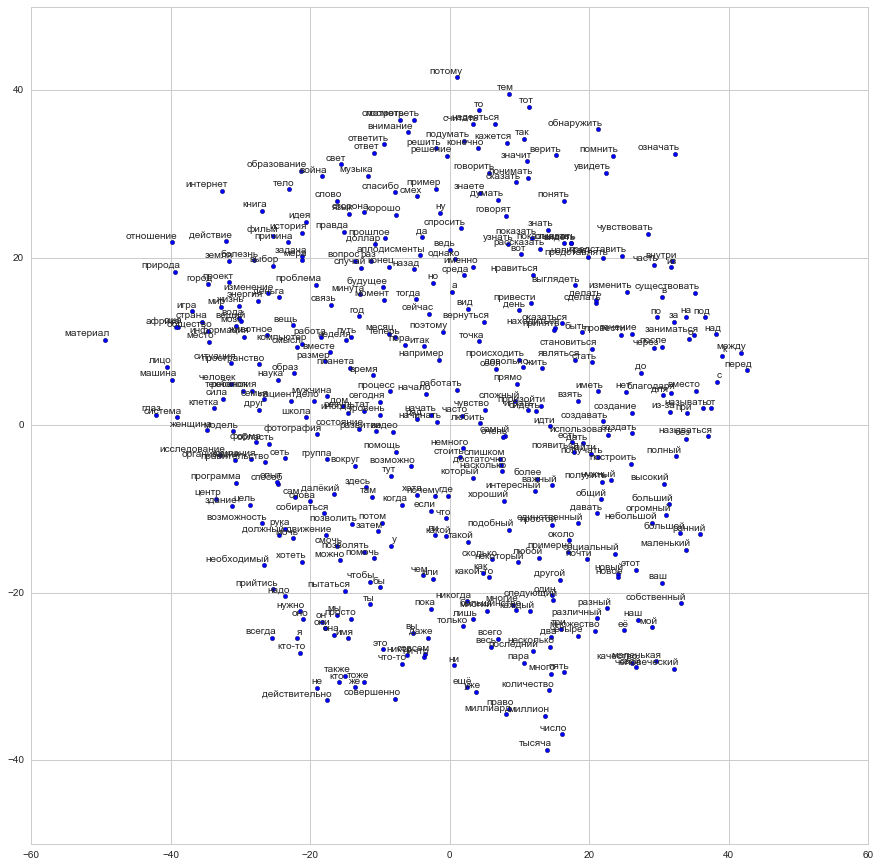

In [15]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [index_to_word[i] for i in range(1, num_points+1)]
plot(my_two_d_embeddings, words)

## Model

In [27]:
class BatchGenerator(object):
    def __init__(self, collection, labels, batch_size, num_unrollings):
        assert len(collection) == len(labels)
        self._collection = collection
        self._labels = labels
        self._num_items = len(collection)
        self._lengths = [len(x) for x in collection]
        self._num_unrollings = num_unrollings
        self._batch_size = batch_size
        self._last_batch = self._next_batch()
        
    def _next_batch(self):
        batch = np.zeros(shape=(self._batch_size), dtype=np.int32)
        idx = rnd.randint(0, self._num_items)
        label = self._labels[idx]
        pos = rnd.randint(0, self._lengths[idx] - self._batch_size - 1)
        
        for i in range(self._batch_size):
            batch[i] = self._collection[idx][pos + i]
            
        return batch, label
    
    def next(self):
        batch, label = self._last_batch
        labels = [label]
        batches = [batch]
        
        for _ in range(self._num_unrollings):
            batch, label = _next_batch()
            batches.append(batch)
            labels.append(label)
            
        self._last_batch = [batches[-1], labels[-1]]
        return batches, labels

class SophisticatedBatchGenerator(object):
    def __init__(self, items, labels, batch_size, num_unrollings):
        self._items = np.array(items)
        self._labels = np.array(labels)
        self._num_items = np.array([len(item) for item in items])
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        label_segment = len(items) // batch_size
        self._label_cursor = np.array([offset * label_segment for offset in range(batch_size)])
        self._item_cursor = np.zeros_like(self._labels, dtype=np.int32)
        self._last_batch = self._next_batch()
  
    def _next_batch(self, reset_state=False):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size), dtype=np.int32)
        labels = self._labels[self._label_cursor]
        
        for i in range(self._batch_size):
            if self._item_cursor[self._label_cursor[i]] < self._num_items[self._label_cursor[i]]:
                row = self._label_cursor[i]
                col = self._item_cursor[row]
            
                batch[i] = self._items[row][col]
                self._item_cursor[row] = self._item_cursor[row] + 1
            else:
                row = self._label_cursor[i]
                col = self._item_cursor[row]
                
                self._item_cursor[row] = self._item_cursor[row] % self._num_items[row]
                self._label_cursor[i] = (self._label_cursor[i] + 1) % len(self._num_items)
                return self._next_batch(reset_state=True) # forget this corrupt batch
        
        return batch, labels, reset_state
  
    def my_next(self, reset_state=False):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        b, l, reset_state = self._last_batch
        batches = [b]
        labels = l
        for step in range(self._num_unrollings):
            b, l, reset_state = self._next_batch()
            if reset_state:
                self._last_batch = [b, l, reset_state]
                return self.my_next(reset_state=True) # forget set of corrupted batches
            batches.append(b)
        self._last_batch = [batches[-1], labels, False]
        return batches, labels, reset_state

In [28]:
batch_size = 50
trunc_by = 10 # number of unfolds
hidden_size = 128 # hidden dimension (to be introduced)
num_classes = 8 # output dimension
input_size = batch_size # max([len(x) for x in X_test])
print 'Maximum input size is %d' % input_size

train_batches = SophisticatedBatchGenerator(X_train, y_train, batch_size, trunc_by)
valid_batches = SophisticatedBatchGenerator(X_valid, y_valid, batch_size, trunc_by)

Maximum input size is 50


In [ ]:
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data
    train_inputs = [tf.placeholder(tf.int32, shape=[batch_size]) for i in range(trunc_by+1)]
    train_labels = tf.placeholder(tf.int32, shape=[batch_size])
    Y = tf.one_hot(train_labels, num_classes)

    # Variables
    # Embedding
    embeddings = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], -1.0, 1.0))
    # Input gate
    input_weights = tf.Variable(tf.truncated_normal([2 * embedding_size, embedding_size], -0.1, 0.1),
                                name='input_weights')
    input_biases = tf.Variable(tf.truncated_normal([1, embedding_size], -0.1, 0.1),
                               name='input_biases')
    # Forget gate
    forget_weights = tf.Variable(tf.truncated_normal([2 * embedding_size, embedding_size], -0.1, 0.1),
                                 name='forget_weights')
    forget_biases = tf.Variable(tf.truncated_normal([1, embedding_size], -0.1, 0.1),
                                name='forget_biases')
    # State cell
    cell_weights = tf.Variable(tf.truncated_normal([2 * embedding_size, embedding_size], -0.1, 0.1),
                               name='cell_weights')
    cell_biases = tf.Variable(tf.truncated_normal([1, embedding_size], -0.1, 0.1),
                              name='cell_biases')
    # Hidden state updates
    hidden_weights = tf.Variable(tf.truncated_normal([embedding_size, embedding_size], -0.1, 0.1),
                                 name='hidden_weights')
    hidden_biases = tf.Variable(tf.truncated_normal([1, embedding_size], -0.1, 0.1),
                                name='hidden_biases')
    # Output gate
    output_weights = tf.Variable(tf.truncated_normal([2 * embedding_size, embedding_size], -0.1, 0.1),
                                 name='output_weights')
    output_biases = tf.Variable(tf.truncated_normal([1, embedding_size], -0.1, 0.1),
                                name='output_biases')
    # Connections
    saved_state = tf.Variable(tf.truncated_normal([batch_size, embedding_size], -0.1, 0.1),
                              name='saved_state')
    saved_h = tf.Variable(tf.truncated_normal([batch_size, embedding_size], -0.1, 0.1),
                          name='saved_h')
    # Classifier
    class_weights = tf.Variable(tf.truncated_normal([embedding_size, num_classes]),
                                  name='class_weights')
    class_biases = tf.Variable(tf.zeros([num_classes]),
                                 name='class_biases')
    
    # Cell
    def lstm_cell(w, h, state):
        i = tf.concat([w, h], 1)
        input_gate = tf.sigmoid(tf.matmul(i, input_weights) + input_biases)
        forget_gate = tf.sigmoid(tf.matmul(i, forget_weights) + forget_biases)
        output_gate = tf.sigmoid(tf.matmul(i, output_weights) + output_biases)
        state_update = tf.tanh(tf.matmul(i, cell_weights) + cell_biases)
        state = forget_gate * state + input_gate * state_update
        state_update = tf.tanh(tf.matmul(state, hidden_weights) + hidden_biases)
        h = output_gate * state_update
        return h, state

    # Model
    def reset(idx):
        saved_h[idx] = 0
        saved_state[idx] = 0
    
    h = saved_h
    state = saved_state
    for w in train_inputs:
        e = tf.nn.embedding_lookup(embeddings, w)
        h, state = lstm_cell(e, h, state)
        
    with tf.control_dependencies([saved_h.assign(h), saved_state.assign(state)]):
        f = tf.nn.xw_plus_b(h, class_weights, class_biases)
        logits = tf.sigmoid(f)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits))
    
    # Optimizer
    gs = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(10., gs, 2000, 0.1, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    
    # Gradients
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=gs)

    # Prediction
    train_prediction = tf.nn.softmax(logits)
    
    # Evaluation
    sample_inputs = [tf.placeholder(tf.int32, [batch_size]) for _ in range(trunc_by+1)]
    saved_sample_h = tf.Variable(tf.zeros([batch_size, embedding_size]), name='saved_sample_h')
    saved_sample_state = tf.Variable(tf.zeros([batch_size, embedding_size]), name='saved_sample_state')
    
    reset_sample_state = tf.group(saved_sample_h.assign(tf.zeros([batch_size, embedding_size])),
                                  saved_sample_state.assign(tf.zeros([batch_size, embedding_size])))
    
    tf.add_to_collection('ops', reset_sample_state)
    
    sample_h = saved_sample_h
    sample_state = saved_sample_state
    for w in sample_inputs:
        e = tf.nn.embedding_lookup(embeddings, w)
        sample_h, sample_state = lstm_cell(e, sample_h, sample_state)

    with tf.control_dependencies([saved_sample_h.assign(sample_h), saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.sigmoid(tf.nn.xw_plus_b(saved_sample_h, class_weights, class_biases)))
        tf.add_to_collection('ops', sample_prediction)
        
    # Saving
    to_save = {'input_weights': input_weights, 'input_biases': input_biases,
               'forget_weights': forget_weights, 'forget_biases': forget_biases,
               'cell_weights': cell_weights, 'cell_biases': cell_biases,
               'hidden_weights': hidden_weights, 'hidden_biases': hidden_biases,
               'output_weights': output_weights, 'output_biases': output_biases,
               'saved_state': saved_state, 'saved_h': saved_h,
               'class_weights': class_weights, 'class_biases': class_biases,
               'saved_sample_h': saved_sample_h, 'saved_sample_state': saved_sample_state,
               'embeddings': embeddings}
    
    saver = tf.train.Saver(to_save)

In [ ]:
num_steps = 50001
print_every = 500
losses = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batches, labels, reset_state = train_batches.my_next()
        if reset_state:
            print 'Reset model state'
            reset(0)
        
        feed_dict = {}
        for i in range(trunc_by + 1):
            feed_dict[train_inputs[i]] = batches[i]
        feed_dict[train_labels] = labels

        opt, l, pred, lr = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        average_loss += l
        if step % print_every == 0:
            if step > 0:
                average_loss = average_loss / print_every
                
            losses.append(average_loss)
            print 'Average loss at step %d: %e learning rate: %e' % (step, average_loss, lr)
            average_loss = 0
            y_predicted = np.argmax(pred, axis=1)
            y_true = labels
            print 'Minibatch accuracy: %.2f' % accuracy_score(y_true, y_predicted)
                  
            if (step % (print_every * 5)) == 0:
                saver.save(session, './model/model')
            
            reset_sample_state.run()
            valid_logprob = 0
            sample_batch, sample_labels, reset_state = valid_batches.my_next()
            if reset_state:
                reset_sample_state.run()
                continue
            validation_dict = {}
            for i in range(trunc_by + 1):
                validation_dict[sample_inputs[i]] = sample_batch[i]
            predictions = sample_prediction.eval(validation_dict)
            predictions = np.argmax(predictions, axis=1)
            print 'Validation set accuracy: %.2f\n' % accuracy_score(np.array(sample_labels), predictions)

Initialized
Average loss at step 0: 2.441373e+00 learning rate: 1.000000e+01
Minibatch accuracy: 0.16
Validation set accuracy: 0.50

Average loss at step 500: 1.737430e+00 learning rate: 1.000000e+01
Minibatch accuracy: 0.54
Validation set accuracy: 0.50



In [ ]:
plt.figure(figsize=(20, 10))

## Testing